<a href="https://colab.research.google.com/github/Thiraput01/Dig_img/blob/main/5_Image_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week #5 Image Restoration

In [1]:
!wget https://drive.google.com/uc?id=1Yox-XWM-PY9vFtDdzB_y_U3SK2paewwe -O kitty.jpg
!wget https://drive.google.com/uc?id=1bl9PxABh2h4irWStbiNNZl3RQxScl08u -O nasa_image.png
!wget https://drive.google.com/uc?id=1rqsQU7PbyrxpnheuzdMxbOVcFSaAps64 -O twins.jpg


--2024-09-20 10:36:52--  https://drive.google.com/uc?id=1Yox-XWM-PY9vFtDdzB_y_U3SK2paewwe
Resolving drive.google.com (drive.google.com)... 108.177.11.100, 108.177.11.113, 108.177.11.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.11.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Yox-XWM-PY9vFtDdzB_y_U3SK2paewwe [following]
--2024-09-20 10:36:52--  https://drive.usercontent.google.com/download?id=1Yox-XWM-PY9vFtDdzB_y_U3SK2paewwe
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79570 (78K) [image/jpeg]
Saving to: ‘kitty.jpg’

kitty.jpg           100%[===================>]  77.71K  --.-KB/s    in 0.001s  

2024-09-20 10:36:54 (86.9 MB/s) - ‘kitty.jpg’ saved [

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.figure import Figure
from skimage import color, data, restoration
from scipy.signal import convolve2d
from math import log10, sqrt

def PSNR(original, estimate):
    mse = np.mean((original - estimate) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.max(original) # 255, 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

## Example #1 Noise

In [3]:
import cv2
from skimage.util import random_noise

img = cv2.imread("twins.jpg",0)

sp = random_noise(img, mode='s&p')
sp2 = random_noise(img, mode='s&p', amount = 0.2)

gauss = random_noise(img, mode='gaussian')
gauss2 = random_noise(img, mode='gaussian',var = 0.002, mean=0.5)

speckle = random_noise(img, mode='speckle')
speckle2 = random_noise(img, mode='speckle', var = 0.2 )



## Exercise #1 Investigate "noisy nasa_image" (img_pn) image using Fourier transform

(250, 333)


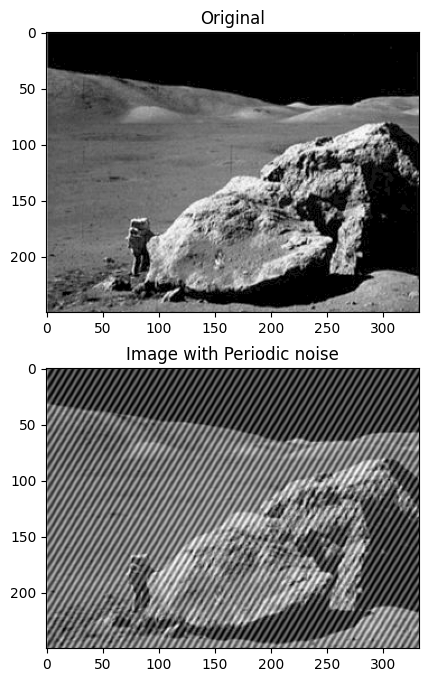

454.99204087556836


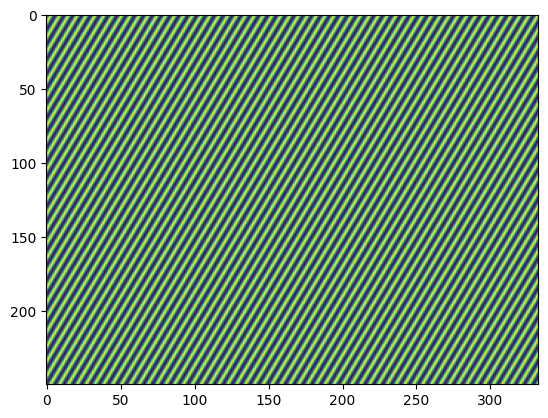

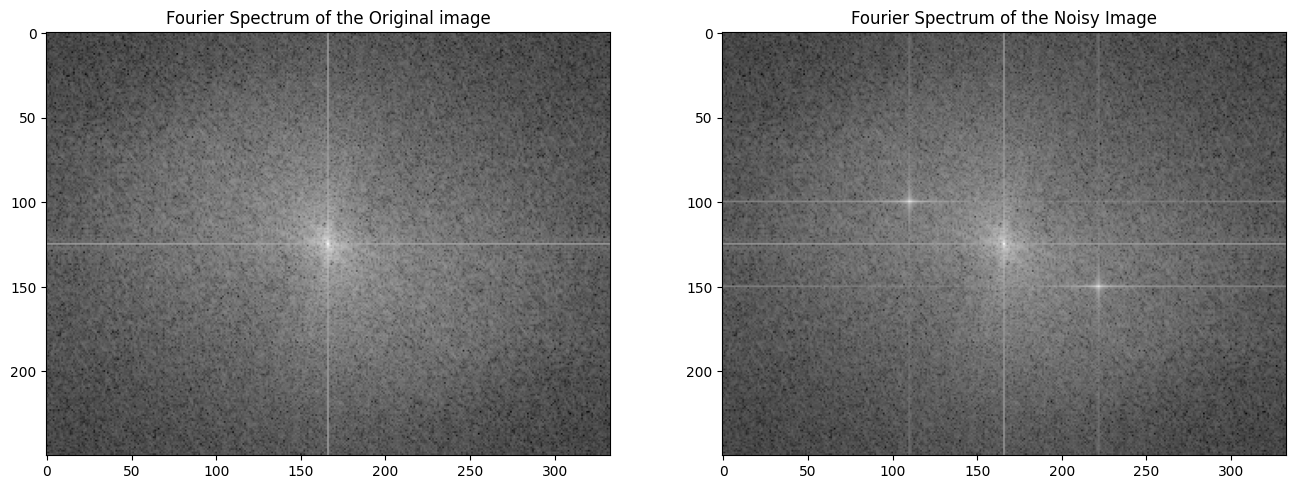

In [12]:
img = cv2.imread("nasa_image.png",0)


# strength
s = 100

nx, ny = img.shape
y = np.linspace(-nx/2,nx/2,nx)
x = np.linspace(-ny/2,ny/2,ny)
xv, yv = np.meshgrid(x,y)
p = s*(np.sin(np.pi*xv/3+np.pi*yv/5)+1.0)
print(img.shape)


img_pn = img.astype(float)+p

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16,8))
fig.add_subplot(2,1,1), plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(2,1,2), plt.imshow(img_pn.astype(int), cmap="gray"), plt.title('Image with Periodic noise')
plt.show()

print(img_pn.max())
plt.imshow(p)
plt.show()


# TO DO - Apply DFT with img_pn and analyze the results
img_pn_frq1 = np.fft.fft2(img)
img_pn_frq_shift1 = np.fft.fftshift(img_pn_frq1)
img_ft_spectrum1 = np.log(1 + np.abs(img_pn_frq_shift1))

img_pn_frq = np.fft.fft2(img_pn)
img_pn_frq_shift = np.fft.fftshift(img_pn_frq)
img_ft_spectrum = np.log(1 + np.abs(img_pn_frq_shift))

fig = plt.figure(figsize=(16, 8))
plt.subplot(121), plt.imshow(img_ft_spectrum1, cmap="gray"), plt.title('Fourier Spectrum of the Original image')
plt.subplot(122), plt.imshow(img_ft_spectrum, cmap="gray"), plt.title('Fourier Spectrum of the Noisy Image')
plt.show()

## Exercise #2 - Apply band reject to the img_pn

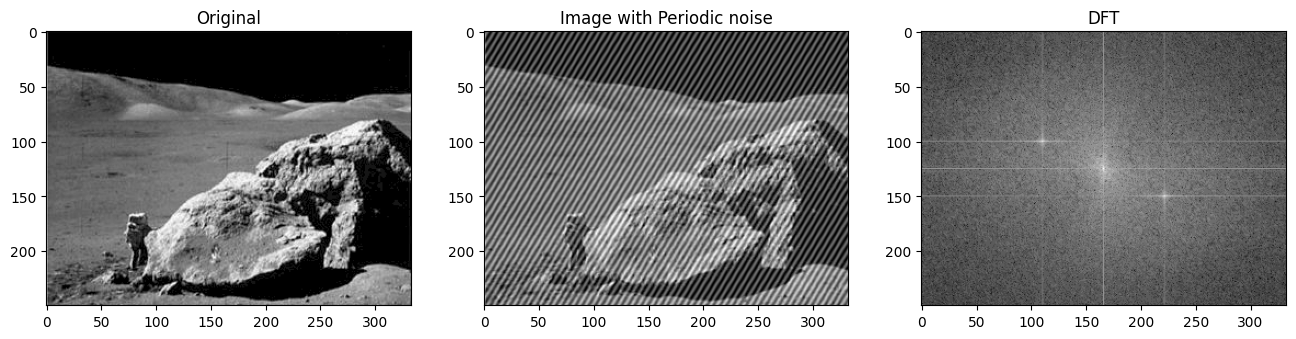

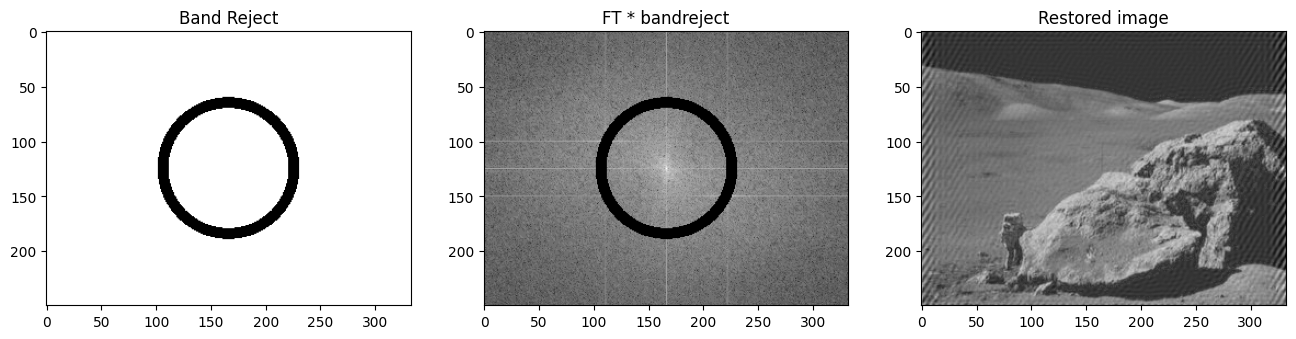

In [31]:
# prepare the coordinate and radius from the center
nx, ny = img.shape
y = np.linspace(-nx/2,nx/2,nx)
x = np.linspace(-ny/2,ny/2,ny)
xv, yv = np.meshgrid(x,y)
radiusCoor = np.sqrt(xv**2 + yv**2)

# identify radius conditions
# TO DO - select appropriate radius here r = __________
r1 = radiusCoor <  55 # inner radius
r2 = radiusCoor >=  65 # outer radius
mask1 = np.ones([nx,ny])
bandReject = cv2.bitwise_or(r1.astype(np.uint8),r2.astype(np.uint8),mask=mask1.astype(np.uint8))

# filtering in frequency domain
img_bandReject = bandReject * img_pn_frq_shift
img_ft_filter_hp_spectrum = np.log(1+np.abs(img_bandReject))

# determine inverse fourier transform
f_ishift_br = np.fft.ifftshift(img_bandReject)
img_restored = np.fft.ifft2(f_ishift_br)
img_restored = np.abs(img_restored)

# display
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1,3,1), plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(1,3,2), plt.imshow(img_pn.astype(int), cmap="gray"), plt.title('Image with Periodic noise')
fig.add_subplot(1,3,3),plt.imshow(img_ft_spectrum.astype(np.uint8), cmap = 'gray'), plt.title('DFT')
plt.show()


fig = plt.figure(figsize = (16,8))
fig.add_subplot(1,3,1), plt.imshow(bandReject, cmap="gray"), plt.title('Band Reject')
fig.add_subplot(1,3,2), plt.imshow(img_ft_filter_hp_spectrum.astype(int), cmap="gray"), plt.title('FT * bandreject')

img_restored = (img_restored-img_restored.min())/(img_restored.max()-img_restored.min()) * 255

img_pn =  (img_pn-img_pn.min())/(img_pn.max()-img_pn.min()) * 255
fig.add_subplot(1,3,3),plt.imshow(img_restored,cmap='gray'),plt.title("Restored image")
plt.show()



## Exercise #3 - Apply notch filter to the img_pn

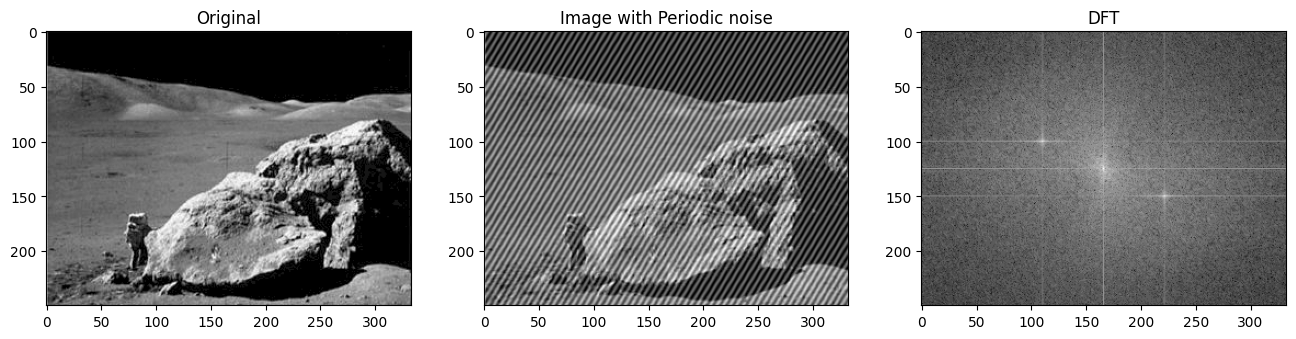

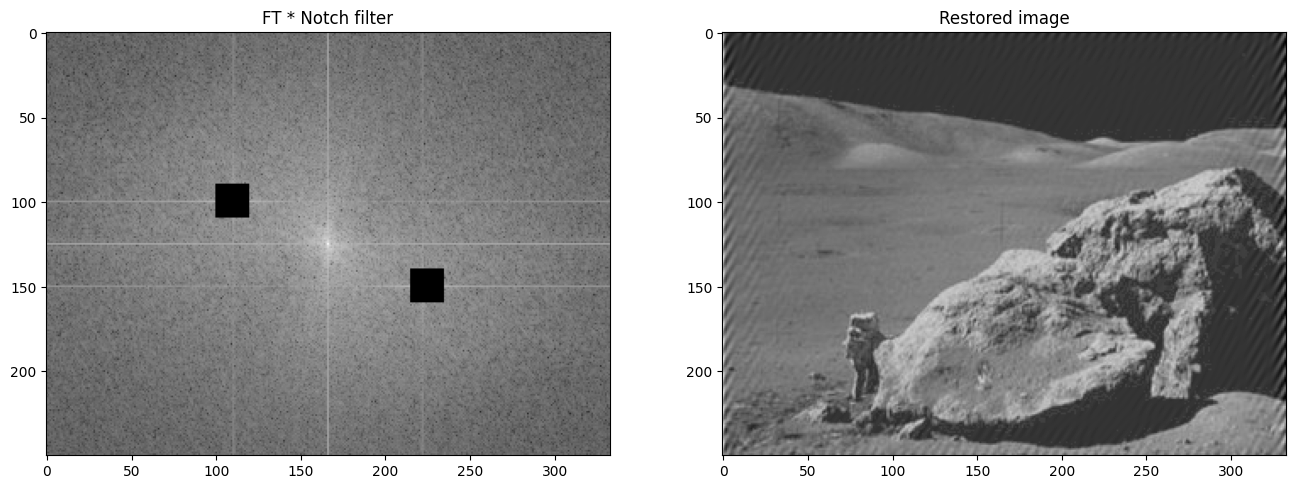

In [48]:

magnitude_spectrum = np.log(1 + np.abs(img_pn_frq))
im_notchFilter = img_pn_frq_shift.copy()

# TO DO - select appropriate range for band stop (set = 0)
im_notchFilter[90:110, 100:120] = 0 # top left
im_notchFilter[140:160, 215:235] = 0 # bottom right

img_ft_filter_nf_spectrum = np.log(1+np.abs(im_notchFilter))

f_ishift_nf = np.fft.ifftshift(im_notchFilter)
img_restored = np.fft.ifft2(f_ishift_nf)
img_restored = np.real(img_restored)
img_restored  = (img_restored - img_restored.min()) / (img_restored.max()-img_restored.min()) * 255

# display
fig = plt.figure(figsize = (16,8))
fig.add_subplot(1,3,1), plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(1,3,2), plt.imshow(img_pn.astype(int), cmap="gray"), plt.title('Image with Periodic noise')
fig.add_subplot(1,3,3),plt.imshow(img_ft_spectrum.astype(np.uint8), cmap = 'gray'), plt.title('DFT')
plt.show()


fig = plt.figure(figsize = (16,8))
fig.add_subplot(1,2,1), plt.imshow(img_ft_filter_nf_spectrum, cmap="gray"), plt.title('FT * Notch filter')

fig.add_subplot(1,2,2),plt.imshow(img_restored,cmap='gray'),plt.title("Restored image")
plt.show()







## Inverse filtering

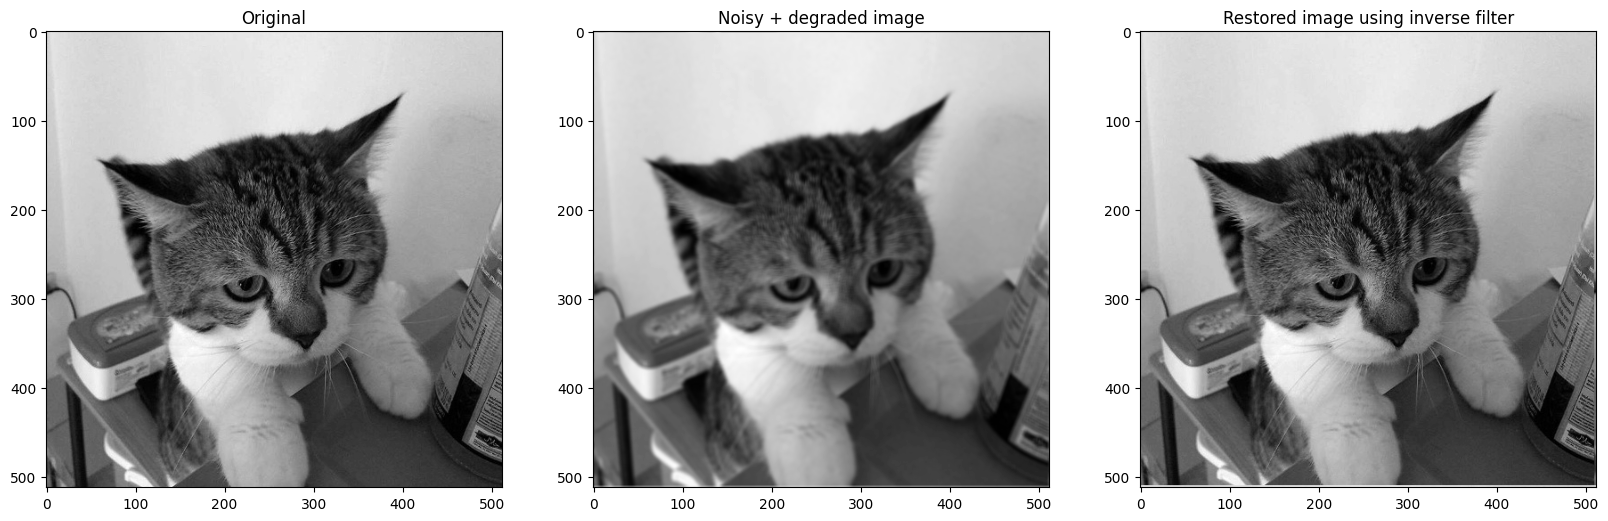

In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Load the original image
img = cv2.imread("kitty.jpg", 0)

# K - ratio of power spectrum of noise (N(u,v)) and original image (F(u,v))
K = 0.07

# create a degraded image
degraded_fn = np.ones((5, 5)) / 25  # averaging filter 5x5
degraded_img = convolve2d(img, degraded_fn, 'same', boundary='wrap')  # degraded image

# H(u,v) - FFT of degraded function
degraded_fn_pad = np.zeros((degraded_img.shape[0], degraded_img.shape[1]))  # padding degraded function to image size
degraded_fn_pad[:degraded_fn.shape[0], :degraded_fn.shape[1]] = degraded_fn
degraded_fft = np.fft.fft2(degraded_fn_pad)  # Fourier transform of the degradation function

# G(u,v) - FFT of observed image
degraded_img_fft = np.fft.fft2(degraded_img)  # Fourier transform of the degraded image

# Apply inverse filtering with regularization to avoid division by zero
restored_img_fft = degraded_img_fft / (degraded_fft)  # inverse filtering in frequency domain

# Convert the result back to spatial domain
restored_img = np.real(np.fft.ifft2(restored_img_fft))  # inverse Fourier transform to get the restored image

# Clip the restored image values to be in the valid range [0, 255]
restored_img[restored_img < 0] = 0
restored_img[restored_img > 255] = 255

# Plotting the results
fig = plt.figure(figsize=(20, 8))

fig.add_subplot(1, 3, 1),
plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(1, 3, 2),
plt.imshow(degraded_img, cmap="gray"), plt.title('Noisy + degraded image')
fig.add_subplot(1, 3, 3)
plt.imshow(restored_img, cmap="gray"), plt.title("Restored image using inverse filter")
plt.show()


## Exercise #4 Wiener Filter

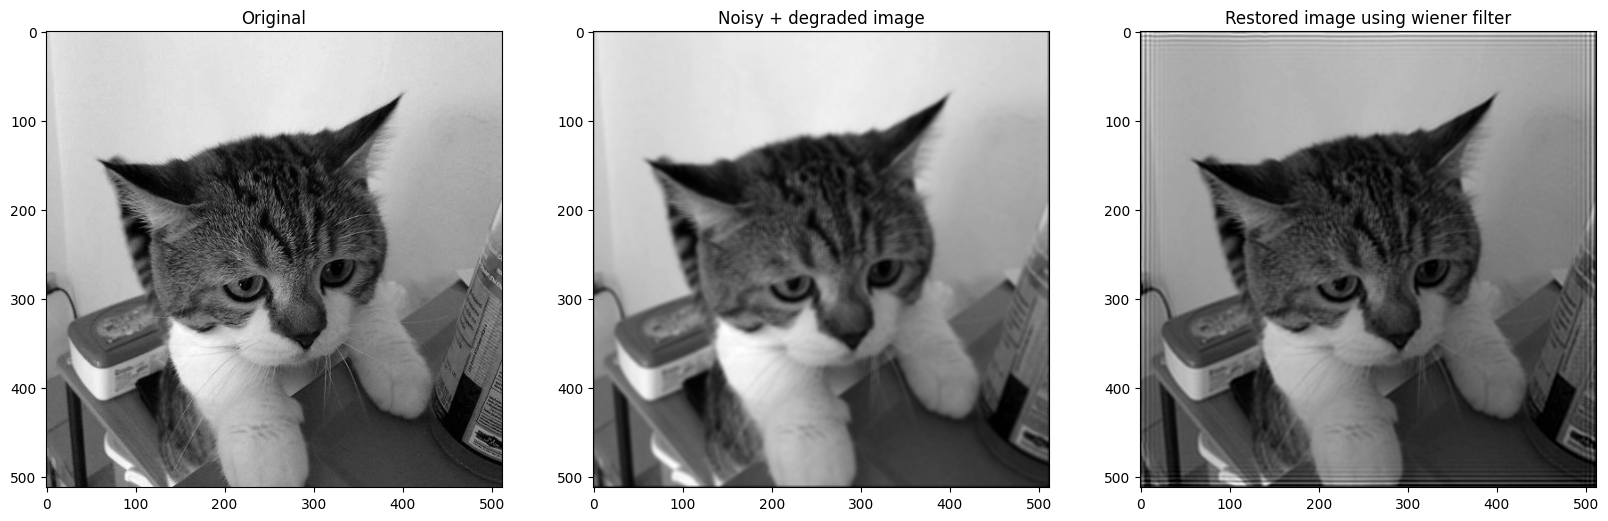

In [78]:
img = cv2.imread("kitty.jpg",0)

# K - ratio of power spectrum of noise (N(u,v)) and original image (F(u,v))
# TO DO : Select K for best restoring the blurred kitty.jpg image
K = 0.01

# create a degraded image
degraded_fn = np.ones((5, 5)) / 25 # averaging filter 5x5
degraded_img = convolve2d(img, degraded_fn, 'same') # degraded image

# H(u,v) - FFT of degraded function
degraded_fn_pad = np.zeros((degraded_img.shape[0],degraded_img.shape[1]))
degraded_fn_pad[:degraded_fn.shape[0],:degraded_fn.shape[1]] = degraded_fn
degraded_fft = np.fft.fft2(degraded_fn_pad)

# G(u,v) - FFT of observed image
degraded_img_fft = np.fft.fft2(degraded_img)
# restored_img = np.real(np.fft.ifft2(degraded_img_fft*np.conjugate(degraded_fft)/(np.abs(degraded_fft)**2 + K)))
restored_img = restoration.wiener(degraded_img / 255, degraded_fn,K) # require a normalized image in a range of [0,1]
restored_img[restored_img<0]  = 0
restored_img[restored_img>255] = 255

fig = plt.figure(figsize = (20,8))
fig.add_subplot(1,3,1),
plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(1,3,2),
plt.imshow(degraded_img, cmap="gray"), plt.title('Noisy + degraded image')
fig.add_subplot(1,3,3)
plt.imshow(restored_img,cmap = "gray"),plt.title("Restored image using wiener filter")
plt.show()